# Query pipeline evaluation example notebook

This notebook serves as a usueable example to evaluate the Kwaak query pipeline. Evaluations are done with RAGAS and it uses itself as datasource.

The intention of this notebook is that it can be modified and tailored for any repository to get a grasp of how the Kwaak rag performs on it.

When generating ground truths, it's expected to not be fully correct. The idea is to have a human in the middle tailor it. The benefit is that it gives both a base to work from and an answer that aligns with the output format of the llm.

Note: Runs questions only once. If you want volume it needs some tailoring.

## How does it work
* Generate a RAGAS compatible dataset with recorded ground truths for a set of questions
* Review and modify the generated initial answers to establish a ground truth
* This stores a /evals/ragas/base.json that will serve as future input
* Make some changes to kwaak, run the eval step without recording ground truth, with the base file as input
* /evals should then contain ragas/base.json and a json file for each evaluation
* Do this as many times as desired, then use the provided analysis (or do it better than me) to make a comparison


## Initial question generation

In this step we will generate our ground truth based on our input questions. A widget is provided to verify and adjust the ground truths.

You **must** confirm the ground truths before continuing. 

In [13]:
questions = [
    "Explain kwaak works and explain the architecture. Include a mermaid diagram of all the high level components.",
"I'd like to be able to configure a session in a file, such that users can add their own custom agents. Create a detailed step-by-step plan.",
"There are multiple uses of channels in the app. Explore how the channels work, interact, relate and explain it in simpel terms from a users perspective.",
"How are tools used by an agent?",
"How can I add a tool for an agent?"
]



In [2]:
import os

current_directory = os.getcwd()
print(current_directory)

# Since by default the dir is in benchmarks/notebooks, set our working directory to the root of the project
%cd ../..

/Users/timonv/projects/kwaak/benchmarks/notebooks
/Users/timonv/projects/kwaak


In [ ]:
# Install depenencies for the duration of the notebook
# Might want to do this proper via uv later!%
pip install ragas itertools pandas matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
# Let's prep these for shell commands so they are double quoted and joined by a comma
questions_for_shell = " ".join([f'-q "{q}"' for q in questions])
print(questions_for_shell)
!RUSTRUST_LOG=debug cargo run --features evaluations --  --allow-dirty eval ragas $questions_for_shell --output=evals/ragas/base_raw.json -r

-q "Explain kwaak works and explain the architecture. Include a mermaid diagram of all the high level components." -q "I'd like to be able to configure a session in a file, such that users can add their own custom agents. Create a detailed step-by-step plan." -q "There are multiple uses of channels in the app. Explore how the channels work, interact, relate and explain it in simpel terms from a users perspective." -q "How are tools used by an agent?" -q "How can I add a tool for an agent?"
 --> src/cli.rs:3:32
  |
3 | use clap::{Parser, Subcommand, ValueEnum};
  |                                ^^^^^^^^^
  |
  = note: `#[warn(unused_imports)]` on by default

    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.60s
     Running `target/debug/kwaak --allow-dirty eval ragas -q 'Explain kwaak works and explain the architecture. Include a mermaid diagram of all the high level components.' -q 'I'\''d like to be able to configure a session in a file, such that users can add the

In [16]:
import pandas as pd;

pd_raw = pd.read_json("evals/ragas/base_raw.json")
pd_raw


,answer,contexts,ground_truth,question
0,The context provided does not offer detailed i...,[Kwaak is free and open-source. You can bring ...,The context provided does not offer detailed i...,Explain kwaak works and explain the architectu...
1,The provided context does not specifically exp...,[## How is Kwaak different from other tools?\n...,The provided context does not specifically exp...,How are tools used by an agent?
2,To configure a session in a file such that use...,[### Session Management\n\nKwaak supports runn...,To configure a session in a file such that use...,I'd like to be able to configure a session in ...
3,The provided context does not contain sufficie...,"[# Architecture\n\nKwaak has a lightweight, ra...",The provided context does not contain sufficie...,There are multiple uses of channels in the app...
4,The provided context does not contain specific...,[//! Agents defines various agents that can be...,The provided context does not contain specific...,How can I add a tool for an agent?


In [19]:
import ipywidgets as widgets
from IPython.display import display

# Create a Textarea widget for each ground truth
textareas = [widgets.Textarea(value=ground_truth.replace('\\n', '\n'), layout=widgets.Layout(width='100%', height='200px')) for ground_truth in pd_raw["ground_truth"]]
pd_base = pd_raw.copy()
base_file = "evals/ragas/base.json"

# Display the Textarea widgets with truncated questions as labels
for i, textarea in enumerate(textareas):
    question_label = pd_raw["question"][i][:100] + "..." if len(pd_raw["question"][i]) > 100 else pd_raw["question"][i]
    display(widgets.Label(f"Question {i+1}: {question_label}"))
    display(textarea)

# Function to get the updated ground truths
def get_updated_ground_truths():
    return [textarea.value for textarea in textareas]

# Button to save the updated ground truths
save_button = widgets.Button(description="Confirm Ground Truths")
display(save_button)

def on_save_button_clicked(b):
    updated_ground_truths = get_updated_ground_truths()

    pd_base = pd_raw.copy()
    # Update the dataframe with the new ground truths
    columns = pd.Series(updated_ground_truths, name="ground_truth")
    pd_base.update(columns)
    
    # Save the updated dataframe back to the JSON file
    pd_base.to_json(base_file, orient='records')
    display(widgets.Label("Ground truths updated and saved successfully!"))

save_button.on_click(on_save_button_clicked)


Label(value='Question 1: Explain kwaak works and explain the architecture. Include a mermaid diagram of all th…

Textarea(value='The context provided does not offer detailed information specific to the complete architecture…

Label(value='Question 2: How are tools used by an agent?')

Textarea(value="The provided context does not specifically explain how tools are used by an agent, in terms of…

Label(value="Question 3: I'd like to be able to configure a session in a file, such that users can add their o…

Textarea(value='To configure a session in a file such that users can add their own custom agents in Kwaak, fol…

Label(value='Question 4: There are multiple uses of channels in the app. Explore how the channels work, intera…

Textarea(value='The provided context does not contain sufficient information to fully explain how channels wor…

Label(value='Question 5: How can I add a tool for an agent?')

Textarea(value="The provided context does not contain specific instructions on how to add a tool for an agent …

Button(description='Confirm Ground Truths', style=ButtonStyle())

Label(value='Ground truths updated and saved successfully!')

In [20]:
pd_base

,answer,contexts,ground_truth,question
0,The context provided does not offer detailed i...,[Kwaak is free and open-source. You can bring ...,The context provided does not offer detailed i...,Explain kwaak works and explain the architectu...
1,The provided context does not specifically exp...,[## How is Kwaak different from other tools?\n...,The provided context does not specifically exp...,How are tools used by an agent?
2,To configure a session in a file such that use...,[### Session Management\n\nKwaak supports runn...,To configure a session in a file such that use...,I'd like to be able to configure a session in ...
3,The provided context does not contain sufficie...,"[# Architecture\n\nKwaak has a lightweight, ra...",The provided context does not contain sufficie...,There are multiple uses of channels in the app...
4,The provided context does not contain specific...,[//! Agents defines various agents that can be...,The provided context does not contain specific...,How can I add a tool for an agent?


## Feature evaluation

We use Rust features to evaluate combinations of features to evaluate the result. This is straightforward and allows checking individual and combinations of multiple features quickly.

In [21]:
features = ["default"]

In [22]:
from itertools import chain, combinations

# Wtf python, why is this not built in?
def powerset(iterable):
    "powerset([1,2,3]) → () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# Now we prep an easy to use list of dicts with the { name, features, output_file }
evals = []
for i, combination in enumerate(list(powerset(features))):
    if len(combination) == 0:
        continue
    evals.append({  "name": "_".join(combination),
                    "features": list(combination),
                    "output_file": f"evals/ragas/{'_'.join(combination)}.json"})
    
evals

[{'name': 'default',
  'features': ['default'],
  'output_file': 'evals/ragas/default.json'}]

In [ ]:
# Now for each eval, we will run kwaak with the given features, with the base.json as input, and output to the output file
from IPython.display import display
from pprint import pprint
base_file  = "evals/ragas/base.json"

for eval in evals:
    display(widgets.Label(f"Running evaluation: {eval['name']}, input from {base_file} outputting to {eval['output_file']}"))
    features = ",".join(eval["features"])
    output_file = eval["output_file"]
    cmd = f"RUST_LOG=debug cargo run --features=evaluations,{features} --  --allow-dirty eval ragas -i {base_file} --output={output_file}"
    pprint(cmd)
    !$cmd

Label(value='Running evaluation: default, input from evals/ragas/base.json outputting to evals/ragas/default.j…

('RUST_LOG=debug cargo run --features=evaluations,default --  --allow-dirty '
 'eval ragas -i evals/ragas/base.json --output=evals/ragas/default.json')
['\x1b\x1b\x1bwarning\x1b\x1b\x1b: unused import: `ValueEnum`\x1b', '\x1b \x1b\x1b\x1b\x1b--> \x1b\x1bsrc/cli.rs:3:32\x1b', '\x1b  \x1b\x1b\x1b\x1b|\x1b', '\x1b\x1b\x1b3\x1b\x1b \x1b\x1b\x1b\x1b|\x1b\x1b \x1b\x1buse clap::{Parser, Subcommand, ValueEnum};\x1b', '\x1b  \x1b\x1b\x1b\x1b|\x1b\x1b                                \x1b\x1b\x1b\x1b^^^^^^^^^\x1b', '\x1b  \x1b\x1b\x1b\x1b|\x1b', '\x1b  \x1b\x1b\x1b\x1b= \x1b\x1b\x1bnote\x1b\x1b: `#[warn(unused_imports)]` on by default\x1b', '', '\x1b\x1bwarning\x1b\x1b:\x1b `kwaak` (lib) generated 1 warning (run `cargo fix --lib -p kwaak` to apply 1 suggestion)', '\x1b\x1b    Finished\x1b `dev` profile [unoptimized + debuginfo] target(s) in 0.61s', '\x1b\x1b     Running\x1b `target/debug/kwaak --allow-dirty eval ragas -i evals/ragas/base.json --output=evals/ragas/default.json`', 'OpenTelemetry tra

In [26]:
# Now we load all the evals into a single dataframe, and we add the features as a column
pd_all = pd.DataFrame()

for eval in evals:
    df_eval = pd.read_json(eval["output_file"])
    df_eval["features"] = ",".join(eval["features"])
    pd_all = pd.concat([pd_all, df_eval], ignore_index=True)

pd_all

,answer,contexts,ground_truth,question,features
0,The provided context does not contain specific...,[Kwaak is free and open-source. You can bring ...,The provided context does not contain specific...,How can I add a tool for an agent?,default
1,The tools used by an agent in the context prov...,[## How is Kwaak different from other tools?\n...,The provided context does not specifically exp...,How are tools used by an agent?,default
2,"Based on the provided context, here is a step-...",[### Arch Linux\n\nThe package is available in...,To configure a session in a file such that use...,I'd like to be able to configure a session in ...,default
3,"Based on the provided context, here is an expl...",[Kwaak is free and open-source. You can bring ...,The context provided does not offer detailed i...,Explain kwaak works and explain the architectu...,default
4,The context provided does not contain specific...,[Kwaak provides a chat interface similar to ot...,The provided context does not contain sufficie...,There are multiple uses of channels in the app...,default


In [35]:
# Runs the evaluations on the gathered data for each feature combination
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)
from ragas import evaluate
from datasets import Dataset
# Convert the dataframe to a Hugging Face dataset
hf_dataset = Dataset.from_pandas(pd_all)

# Now let's add evaluation metrics to each row in the dataset
all_results = []
for features, df in pd_all.groupby("features"):
    hf_dataset = Dataset.from_pandas(df)
    results = evaluate(hf_dataset, metrics=[answer_relevancy, faithfulness, context_recall, context_precision]).to_pandas()
    results["features"] = features
    all_results.append(results)

# Convert the updated dataframe back to a Hugging Face dataset
all_results
   

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

[                                          user_input  \
 0                 How can I add a tool for an agent?   
 1                    How are tools used by an agent?   
 2  I'd like to be able to configure a session in ...   
 3  Explain kwaak works and explain the architectu...   
 4  There are multiple uses of channels in the app...   
 
                                   retrieved_contexts  \
 0  [Kwaak is free and open-source. You can bring ...   
 1  [## How is Kwaak different from other tools?\n...   
 2  [### Arch Linux\n\nThe package is available in...   
 3  [Kwaak is free and open-source. You can bring ...   
 4  [Kwaak provides a chat interface similar to ot...   
 
                                             response  \
 0  The provided context does not contain specific...   
 1  The tools used by an agent in the context prov...   
 2  Based on the provided context, here is a step-...   
 3  Based on the provided context, here is an expl...   
 4  The context provided do

In [ ]:
import pandas as pd

# Merge all results into a single dataframe
merged_results = pd.concat(all_results, ignore_index=True)
merged_results

,user_input,retrieved_contexts,response,reference,answer_relevancy,faithfulness,context_recall,context_precision,features
0,How can I add a tool for an agent?,[Kwaak is free and open-source. You can bring ...,The provided context does not contain specific...,The provided context does not contain specific...,0.000000,1.000000,1.000000,1.000000,default
1,How are tools used by an agent?,[## How is Kwaak different from other tools?\n...,The tools used by an agent in the context prov...,The provided context does not specifically exp...,0.963323,1.000000,0.923077,0.901089,default
2,I'd like to be able to configure a session in ...,[### Arch Linux\n\nThe package is available in...,"Based on the provided context, here is a step-...",To configure a session in a file such that use...,0.869238,0.692308,0.818182,0.927719,default
3,Explain kwaak works and explain the architectu...,[Kwaak is free and open-source. You can bring ...,"Based on the provided context, here is an expl...",The context provided does not offer detailed i...,0.913148,0.833333,1.000000,0.038462,default
4,There are multiple uses of channels in the app...,[Kwaak provides a chat interface similar to ot...,The context provided does not contain specific...,The provided context does not contain sufficie...,0.000000,1.000000,1.000000,0.000000,default


# Visuals

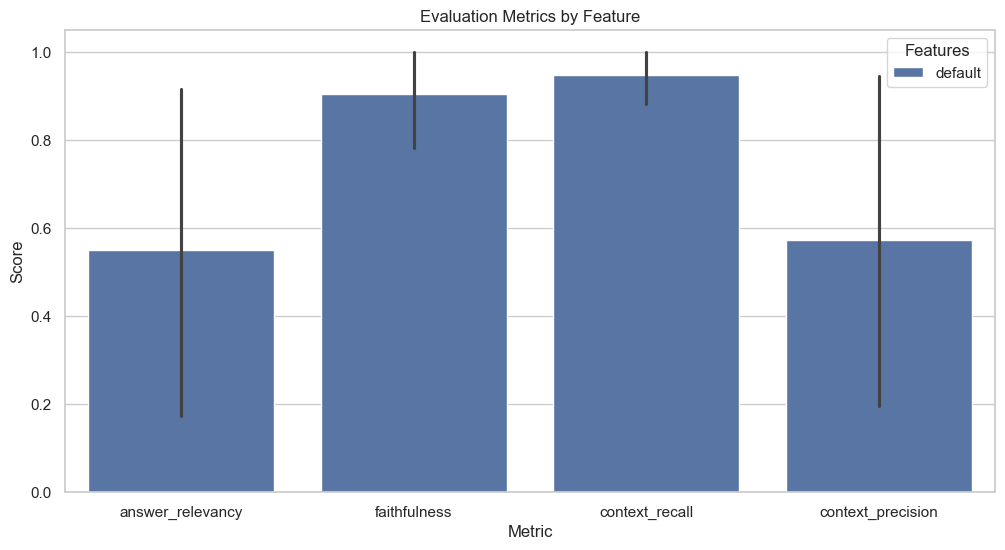

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Convert the merged_results dataframe to long format for easier plotting
metrics_long = pd.melt(merged_results, id_vars=["user_input", "features"], 
                       value_vars=["answer_relevancy", "faithfulness", "context_recall", "context_precision"],
                       var_name="metric", value_name="value")

# Create a bar plot for the evaluation metrics
plt.figure(figsize=(12, 6))
sns.barplot(x="metric", y="value", hue="features", data=metrics_long)
plt.title("Evaluation Metrics by Feature")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Features")
plt.show()


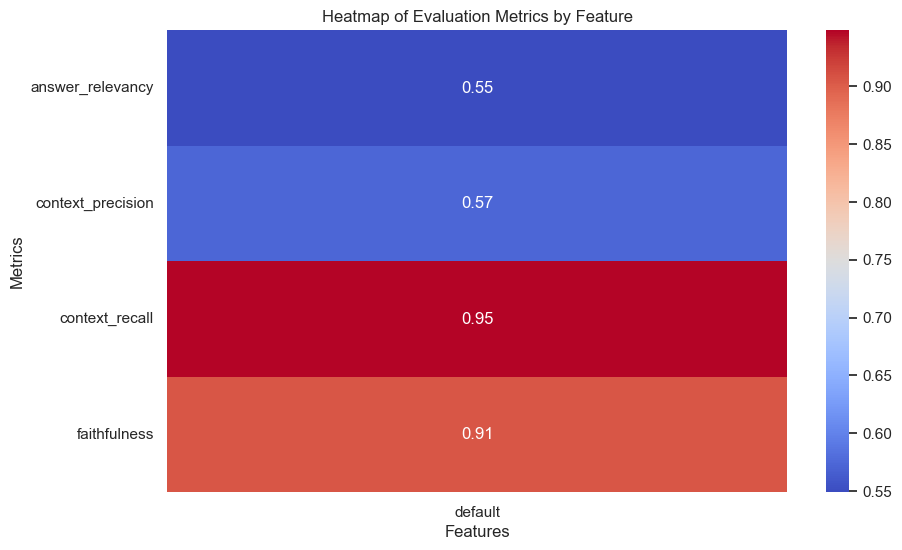

In [ ]:
# Create a heatmap so we can see how the data moves
heatmap_data = metrics_long.pivot_table(index='metric', columns='features', values='value')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar=True)
plt.title("Heatmap of Evaluation Metrics by Feature")
plt.ylabel("Metrics")
plt.xlabel("Features")
plt.show()